# CAP5610 Final Project: Building an Image Classifier for Animal Images
By William Tecchio, Justin Trout, and Judson Murray



# Introduction

In this notebook, we attempt to utilize the concepts learned throughout this course to build an image classification model using PyTorch, that will be able to classify the type of animal present across 10 different classes of animals. The data we will be using is a Kaggle dataset called “Animals-10” that was prepared by Corrado Alessio (@alessiocorrado99 on Kaggle). This dataset contains 26,179 images of animals from the following classes: sheep, horse, cow, dog, cat, squirrel, spider, chicken, elephant, and butterfly; and each class contains between two and five thousand images of a specific animal in different contexts. Our problem is a supervised classification problem, where we first split the data, and use the training image-label pairs to train our model (with the label being the type of animal), then evaluate on our testing set. Additionally, since our data was originally organized in Italian, we ran a translator script in order to translate our label names into English.

In this project, we examine two main model architectures, first is a traditional Convolutional Neural Network (CNN) approach to perform the classification, implementing our model using the keras library in conjunction with PyTorch. We selected this model as this is a model that is understood to be generally good at image classification. The other model we want to explore is a hybrid model architecture consisting of a pretrained foundation model making up our base layers, and a Transformer Encoder head. Our hope with this model was to combine some of the concepts we have covered in this class in order to achieve great results, as well as showcase the performance increase that comes from using the hybrid model approach relative to a traditional CNN. 

# Part 1: Data Exploration and Preprocessing

In order to load our data and process it such that we can use it for our modeling purposes, we had to utilize several commonly used image preprocessing techniques. Our approach to this was to define a set of transformations to be applied to the image, and then apply that transformation to the data as we loaded it into our notebook. Luckily, using the torchvision library, we can do this in one function call using the torchvision.datasets.ImageFolder() function. This function loads in the image data from a local directory that we define, and returns a dataset where the image samples have been converted to tensor-label pairs to be used for modeling. With this approach we can call our transformation directly when loading in the data. The specific transformation criteria we chose to use were resizing and normalization, so that we could achieve more efficient and stable training once we have defined our models. 

Once our data was loaded, we created PyTorch DataLoaders for each of our sets: Training, Validation, and Testing. Using this approach, we can efficiently iterate over our data in batches, instead of trying to load over 26,000 images into memory, which would surely cause us some issues. Also, we wrote a short function to visualize a few of our samples for reference. 

Using device: cuda


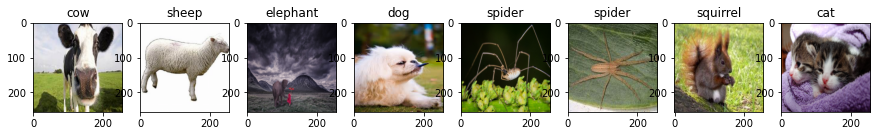

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set data directory
data_dir = '../../Resources/Animals-10'

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define inverse transform to reverse the normalization
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
])

# Load data using torchvision.datasets.ImageFolder
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

# Create data loaders
batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Apply the inverse transform to each image before visualization
def visualize_batch(batch):
    images, labels = batch
    fig, ax = plt.subplots(ncols=8, figsize=(15, 15))
    for idx in range(8):
        img = inverse_transform(images[idx]).clamp(0, 1)  # Clamp the values to the range [0, 1] after inverse normalization
        ax[idx].imshow(img.permute(1, 2, 0).numpy())
        ax[idx].title.set_text(dataset.classes[labels[idx]])
    plt.show()


# Get a batch of data
batch = next(iter(train_loader))
visualize_batch(batch)

# Part 2: Traditional CNN Model

In this section, we created the first model. For our CNN model, we utilied 4 convolutional layers of different sizes, each with a pooling layer and a batch normalization layer after. These secondary layers each play an important role. By utilizing pooling layers, we can reduce the spatial dimensions of our model to keep the computational cost of training as low as possible, resulting in more efficient training. Similarly, by incorporating batch normalization layers, we are ensuring smooth gradient flows as well as attempting to mitigate cases where the model could overfit, which both help us ensure our training is trustworthy and efficient. We also experiemented with dropout layers in different spots with different weights on a trial-and-error basis to maximize the performance we could acheive with this model approach. 

For training our model, we used the Cross Entropy Loss function from torch.nn, which is generally suitable for multi-class classification models such as ours. Additonally, our choice of loss optimizer was the Adam optimizer. 

In [3]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the CNN model
class AnimalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AnimalClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.dropout3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = nn.functional.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = nn.functional.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = nn.functional.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout3(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Create an instance of the model
num_classes = len(dataset.classes)
model = AnimalClassifier(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and validation loop
num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average loss over the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:33<00:00,  6.11it/s]


Epoch [1/30], Loss: 1.6680, Validation Accuracy: 50.79%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:26<00:00,  6.60it/s]


Epoch [2/30], Loss: 1.2879, Validation Accuracy: 56.35%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.92it/s]


Epoch [3/30], Loss: 1.1087, Validation Accuracy: 59.37%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.95it/s]


Epoch [4/30], Loss: 0.9772, Validation Accuracy: 61.47%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.95it/s]


Epoch [5/30], Loss: 0.8854, Validation Accuracy: 65.35%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.77it/s]


Epoch [6/30], Loss: 0.8043, Validation Accuracy: 66.13%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.77it/s]


Epoch [7/30], Loss: 0.7239, Validation Accuracy: 67.45%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.93it/s]


Epoch [8/30], Loss: 0.6495, Validation Accuracy: 67.97%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.76it/s]


Epoch [9/30], Loss: 0.5857, Validation Accuracy: 69.95%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.91it/s]


Epoch [10/30], Loss: 0.5316, Validation Accuracy: 70.39%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:26<00:00,  6.61it/s]


Epoch [11/30], Loss: 0.4814, Validation Accuracy: 72.09%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.95it/s]


Epoch [12/30], Loss: 0.4194, Validation Accuracy: 72.17%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.95it/s]


Epoch [13/30], Loss: 0.3810, Validation Accuracy: 72.80%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:25<00:00,  6.73it/s]


Epoch [14/30], Loss: 0.3315, Validation Accuracy: 73.51%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.76it/s]


Epoch [15/30], Loss: 0.2973, Validation Accuracy: 73.24%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:26<00:00,  6.60it/s]


Epoch [16/30], Loss: 0.2714, Validation Accuracy: 73.31%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.94it/s]


Epoch [17/30], Loss: 0.2397, Validation Accuracy: 74.06%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:29<00:00,  6.42it/s]


Epoch [18/30], Loss: 0.2103, Validation Accuracy: 73.98%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.78it/s]


Epoch [19/30], Loss: 0.1894, Validation Accuracy: 73.87%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.78it/s]


Epoch [20/30], Loss: 0.1708, Validation Accuracy: 73.96%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:26<00:00,  6.60it/s]


Epoch [21/30], Loss: 0.1595, Validation Accuracy: 73.89%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.94it/s]


Epoch [22/30], Loss: 0.1484, Validation Accuracy: 74.40%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.96it/s]


Epoch [23/30], Loss: 0.1367, Validation Accuracy: 74.10%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.94it/s]


Epoch [24/30], Loss: 0.1201, Validation Accuracy: 73.68%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.95it/s]


Epoch [25/30], Loss: 0.1139, Validation Accuracy: 74.65%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.78it/s]


Epoch [26/30], Loss: 0.1082, Validation Accuracy: 74.33%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.78it/s]


Epoch [27/30], Loss: 0.1003, Validation Accuracy: 74.65%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.79it/s]


Epoch [28/30], Loss: 0.0970, Validation Accuracy: 74.36%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:22<00:00,  6.96it/s]


Epoch [29/30], Loss: 0.0949, Validation Accuracy: 74.46%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [01:24<00:00,  6.79it/s]


Epoch [30/30], Loss: 0.0929, Validation Accuracy: 74.04%


# Results from Model 1

As we expected, our first model performed fairly well at predicting the classes of animals in our dataset, with a final validation accuracy of around 74%, and the training loss and validation accuracy both converging pretty smoothly. Although this is decent, we were hoping to get very good results for our final classifier (closer to 80-90% accuracy), and think we can acheive this by constructing a model using the hybrid approach defined above in the introduction. 

The training of model one can be visualized below: 



In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))


color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, label='Training Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accuracy (%)', color=color)  
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  
plt.title('Training Loss and Validation Accuracy over Epochs on CNN')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


plt.savefig('training_validation_plot_CNN.png', dpi=300)  

plt.show()


# Part 3: Hybrid Model with Pretrained Model, Transformer Encoder, and Learning Rate Scheduler

In this section, we implement the hybrid model architecture consisting of a pretrained foundation model, and including a Transformer Encoder layer as the head to be trained on our data. The foundation model we chose to include was the 'Resnet50' model, which is a 50 layer Convolutional Neural Network model created by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in the paper "Deep Residual Learning for Image Recognition." This model was trained on the massive 'ImageNet' dataset, and is generally good at computer vision tasks such as feature extraction and image classification. Our approach was to use the weights from the Resnet50 model as the base layers for our classifier, feed our input data through those layers, and then train the final Encoder layer on our data to make predictions.The final step in improving our modeling process was to add a learning rate scheduler to our hybrid approach to guide the training process of our model in the hopes that we could achieve more proficient and smooth model training, and overall better results.  

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.models import resnet50
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

class AnimalClassifier(nn.Module):
    def __init__(self, num_classes, feature_size=2048, num_layers=2, num_heads=8, dropout=0.1):
        super(AnimalClassifier, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.feature_size = feature_size
        
        # Transformer Encoder
        encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Transformer Decoder
        decoder_layer = TransformerDecoderLayer(d_model=feature_size, nhead=num_heads)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Final linear layer
        self.fc = nn.Linear(feature_size, num_classes)
        
    def forward(self, src, tgt):
        # Extract features from ResNet
        src_features = self.resnet(src)
        tgt_features = self.resnet(tgt)

        # Ensure both source and target features have batch dimension
        src_features = src_features.unsqueeze(0)  # Add batch dimension
        tgt_features = tgt_features.unsqueeze(0)  # Add batch dimension

        # Encoder forward pass
        src_encoded = self.transformer_encoder(src_features)

        # Decoder forward pass
        tgt_encoded = self.transformer_decoder(tgt_features, src_encoded)

        # Remove batch dimension before classification
        src_encoded = src_encoded.squeeze(0)
        tgt_encoded = tgt_encoded.squeeze(0)

        # Classification layer
        output = self.fc(tgt_encoded)
        return output

# Create an instance of the model
num_classes = len(dataset.classes)
model = AnimalClassifier(num_classes).to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Training loop with learning rate scheduling
num_epochs = 30
total_steps = len(train_loader)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images, images)  # Pass the same images as source and target for simplicity
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Save the training loss for plotting
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, images)  # Using the same images as source and target
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)  # Save the validation accuracy for plotting
        print(f'Validation Accuracy after Epoch [{epoch+1}]: {val_accuracy:.2f}%')

    # Adjust learning rate based on validation performance
    scheduler.step(epoch_loss)

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images, images)  # Using the same images as source and target
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {test_accuracy:.2f}%')

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:44<00:00,  3.48it/s]


Epoch [1/30], Loss: 0.2893
Validation Accuracy after Epoch [1]: 93.96%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:46<00:00,  3.44it/s]


Epoch [2/30], Loss: 0.1764
Validation Accuracy after Epoch [2]: 94.23%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:46<00:00,  3.45it/s]


Epoch [3/30], Loss: 0.1358
Validation Accuracy after Epoch [3]: 94.94%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:43<00:00,  3.51it/s]


Epoch [4/30], Loss: 0.0987
Validation Accuracy after Epoch [4]: 95.53%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:52<00:00,  3.31it/s]


Epoch [5/30], Loss: 0.1041
Validation Accuracy after Epoch [5]: 94.04%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:52<00:00,  3.31it/s]


Epoch [6/30], Loss: 0.1078
Validation Accuracy after Epoch [6]: 94.14%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:55<00:00,  3.26it/s]


Epoch [7/30], Loss: 0.0909
Validation Accuracy after Epoch [7]: 93.45%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:54<00:00,  3.29it/s]


Epoch [8/30], Loss: 0.0858
Validation Accuracy after Epoch [8]: 95.66%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:59<00:00,  3.20it/s]


Epoch [9/30], Loss: 0.0776
Validation Accuracy after Epoch [9]: 95.24%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:47<00:00,  3.43it/s]


Epoch [10/30], Loss: 0.0664
Validation Accuracy after Epoch [10]: 95.38%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:46<00:00,  3.45it/s]


Epoch [11/30], Loss: 0.0690
Validation Accuracy after Epoch [11]: 94.59%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:46<00:00,  3.43it/s]


Epoch [12/30], Loss: 0.0611
Validation Accuracy after Epoch [12]: 94.96%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:43<00:00,  3.49it/s]


Epoch [13/30], Loss: 0.0673
Validation Accuracy after Epoch [13]: 94.44%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.59it/s]


Epoch [14/30], Loss: 0.0767
Validation Accuracy after Epoch [14]: 95.45%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.60it/s]


Epoch [15/30], Loss: 0.0481
Validation Accuracy after Epoch [15]: 93.77%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.59it/s]


Epoch [16/30], Loss: 0.0439
Validation Accuracy after Epoch [16]: 95.19%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:40<00:00,  3.58it/s]


Epoch [17/30], Loss: 0.0535
Validation Accuracy after Epoch [17]: 95.36%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:42<00:00,  3.53it/s]


Epoch [18/30], Loss: 0.0622
Validation Accuracy after Epoch [18]: 94.35%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.60it/s]


Epoch [19/30], Loss: 0.0620
Validation Accuracy after Epoch [19]: 93.60%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.59it/s]


Epoch [20/30], Loss: 0.0682
Validation Accuracy after Epoch [20]: 95.22%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:41<00:00,  3.54it/s]


Epoch [21/30], Loss: 0.0146
Validation Accuracy after Epoch [21]: 96.18%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:41<00:00,  3.54it/s]


Epoch [22/30], Loss: 0.0047
Validation Accuracy after Epoch [22]: 96.20%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:39<00:00,  3.59it/s]


Epoch [23/30], Loss: 0.0029
Validation Accuracy after Epoch [23]: 96.28%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:38<00:00,  3.62it/s]


Epoch [24/30], Loss: 0.0046
Validation Accuracy after Epoch [24]: 96.31%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:37<00:00,  3.64it/s]


Epoch [25/30], Loss: 0.0032
Validation Accuracy after Epoch [25]: 96.26%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:37<00:00,  3.63it/s]


Epoch [26/30], Loss: 0.0023
Validation Accuracy after Epoch [26]: 96.58%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:41<00:00,  3.54it/s]


Epoch [27/30], Loss: 0.0016
Validation Accuracy after Epoch [27]: 96.66%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:53<00:00,  3.30it/s]


Epoch [28/30], Loss: 0.0029
Validation Accuracy after Epoch [28]: 96.18%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:49<00:00,  3.38it/s]


Epoch [29/30], Loss: 0.0025
Validation Accuracy after Epoch [29]: 96.41%


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [02:55<00:00,  3.27it/s]


Epoch [30/30], Loss: 0.0013
Validation Accuracy after Epoch [30]: 96.62%
Accuracy of the model on the test images: 97.21%


### save weights

In [15]:
# Define the filename
model_filename = 'animal_classifier_state_dict.pth'

# Save the model state_dict in the root directory of the Jupyter server
torch.save(model.state_dict(), model_filename)

print(f"Model state_dict saved to {model_filename}")

Model state_dict saved to animal_classifier_state_dict.pth


### save whole model

In [7]:
torch.save(model, 'model.pth')

# Results from Model 2

As we can see, converting our model architecture from traditional CNN to the hybrid model described in this section seemed to massively improve our model performance, with our training loss dropping significantly, and our validation accuracy increasing to around 96%, and increase of around 22% accuracy! Although we expected the results of this model to be better, we were astonished by just how much better the performance of this model was relative to our first model. Additionally, when evaluating on the heldout test set that was unseen to the model during training, we found that our model predicted with 97% accuracy, indicating that it generalizes well on out of sample data. 

The training for Model 3 can be visualized below, note that the validation accuracy appears less smooth but converges towards the later epochs, this can be attributed to the scheduled learning rate incorporated in this attempt: 

In [ ]:
# Training Visualization for Model 2

epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(12, 6))


color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, label='Training Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accuracy (%)', color=color)  
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
fig.tight_layout()  # For layout
plt.title('Training Loss and Validation Accuracy over Epochs on Transformer Model')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


plt.savefig('training_validation_plot_Transformer.png', dpi=300) 
plt.show()


# Part 5: Conclusions 

In our project, we were able to incorporate several of the concepts learned throughout this course in order to build a relatively successful image classifier, including standard model building and evaluation techniques, as well as utilizing some newer model architectures in order to optimize our performance. The first and main conclusion we were able to make was that the Transformer model architecture in conjunction with a pretrained base model vastly outperformed the traditional Convolutional Neural Network for our specific image classification task. However, this was expected and we wanted to use this project as a showcase of just how much better our more modern approach was over just using a CNN, which we were able to accomplish. 

Challenges that arose during this project came primarily from feasability issues of training our model. Some of the model architectures we chose to work with are complex in nature, and required a lot of computational power to train, and as a result not all of our team members were able to run all of the models on their personal machines causing us to have to brainstorm other ideas on how to convert our model approaches to other platforms with stronger GPU's such as Google Colab. Another challenge also came from the time loss we incurred from exploring the Transformer model further and conducting preliminary research as none of our team members were that experienced with building and training these models. 

If the work for this project were to be continued, our goal would be to update our training data to include more classes of animals, or potentially update it to classify at a more granular level, such as identifying the species of a specific type of animal. However, the potential for this type of model really is limitless in terms of what it is capable of classifying, and it could be tuned to perform image classification for an extremely wide variety of things. 




## References


1. Resnet50 Paper -  https://www.cvfoundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf 

2. Original Kaggle Dataset - https://www.kaggle.com/datasets/alessiocorrado99/animals10 

3. Final Project GitHub Repository (via William Tecchio) - https://github.com/Wtecchio/Animal_classifier_website

4. Transformer Encoder Documentation - https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html



